# Modelo de OneClassSVM entrenado con 4F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma
- betaRel

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- '../data/astro_df.txt`

In [812]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [813]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [814]:
data_path = "../data/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')
print(f" Nombres de las columnas: {list(df_astro.columns)}")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"astro_DM": "class"})

print(f"Dataset cargado. Forma: {df_astro.shape}")
print(f"Nombres de las columnas: {list(df_astro.columns)}")

display(df_astro.head())


 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
Dataset cargado. Forma: (2831, 5)
Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'class']


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [815]:
# Selección de características
features = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
"""Establecemos la columna objetivo aunque al ser un problema de detección de anomalías no la utilizaremos para entrenar el modelo.
Además de que todos los datos están etiquetados como 'astro_DM' = 0.0"""
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# Comprobamos valores nulos
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
Columna objetivo: class

 Valores faltantes por columna:
Log(E_peak)      0
Log(beta)        0
Log(sigma)       0
Log(beta_Rel)    0
class            0
dtype: int64

 Muestra del dataset:


,Log(E_peak),Log(beta),Log(sigma),Log(beta_Rel),class
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


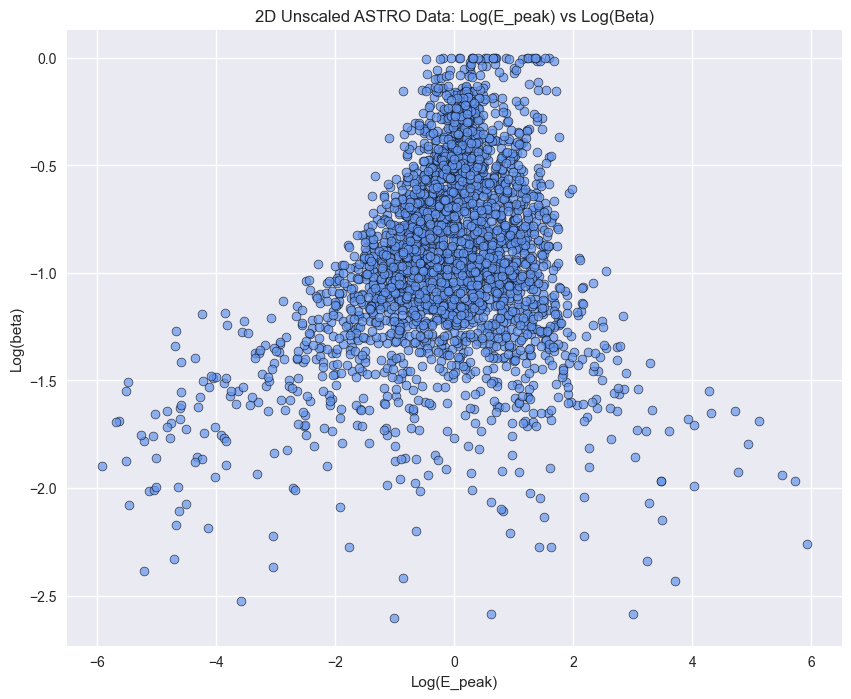

In [816]:
# Representación 2D
plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=df_astro,
    x="Log(E_peak)",
    y="Log(beta)",
    color="cornflowerblue",  # "skyblue" "cornflowerblue"
    edgecolor='k',
    alpha=0.7,
    s=40
)

plt.title("2D Unscaled ASTRO Data: Log(E_peak) vs Log(Beta)")
plt.xlabel("Log(E_peak)")
plt.ylabel("Log(beta)")
plt.grid(True)
plt.show()

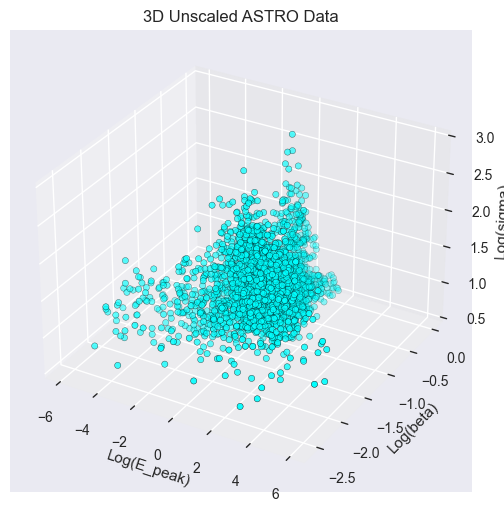

In [817]:
# Representación 3D
x = df_astro['Log(E_peak)']
y = df_astro['Log(beta)']
z = df_astro['Log(sigma)']

labels = df_astro['class']

# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k')

ax.set_xlabel('Log(E_peak)')
ax.set_ylabel('Log(beta)')
ax.set_zlabel('Log(sigma)')
plt.title('3D Unscaled ASTRO Data')
plt.show()


In [818]:

# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro[target].values

# Split: Train / Val / Test
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hacemos una división estratificada para mantener la proporción de clases
# First stratified split: 60% train, 40% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second stratified split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [819]:
print("Forma de X_train_scaled:", X_train_scaled.shape)
print("Forma de X_val_scaled:"  , X_val_scaled.shape)
print("Forma de X_test_scaled:", X_test_scaled.shape)

Forma de X_train_scaled: (1698, 4)
Forma de X_val_scaled: (566, 4)
Forma de X_test_scaled: (567, 4)


In [820]:
def plot_decision_boundaries_4f(X_train, X_val, X_test, y_train, y_val, y_test, 
                               nu_values, gamma_values, feature_names):
    """
    Visualiza fronteras de decisión para todas las combinaciones 2D de las 4 características
    """
    
    # Todas las combinaciones de 2 características de las 4
    feature_pairs = list(combinations(range(4), 2))
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    results_summary = []
    
    for pair_idx, (feat1, feat2) in enumerate(feature_pairs):
        ax = axes[pair_idx]
        
        # Seleccionar solo 2 características para esta visualización
        X_train_2d = X_train[:, [feat1, feat2]]
        X_val_2d = X_val[:, [feat1, feat2]]
        X_test_2d = X_test[:, [feat1, feat2]]
        
        # Escalar para esta proyección específica
        scaler_2d = StandardScaler()
        X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
        X_val_2d_scaled = scaler_2d.transform(X_val_2d)
        X_test_2d_scaled = scaler_2d.transform(X_test_2d)
        
        best_outliers = np.inf
        best_model_2d = None
        best_params_2d = {}
        
        # Grid search para esta proyección 2D
        for nu in nu_values:
            for gamma in gamma_values:
                model_2d = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
                model_2d.fit(X_train_2d_scaled)
                
                val_preds = model_2d.predict(X_val_2d_scaled)
                n_outliers = np.sum(val_preds == -1)
                
                if n_outliers < best_outliers:
                    best_outliers = n_outliers
                    best_model_2d = model_2d
                    best_params_2d = {'nu': nu, 'gamma': gamma}
        
        # Crear grid para visualizar frontera
        x_min, x_max = X_train_2d_scaled[:, 0].min() - 1, X_train_2d_scaled[:, 0].max() + 1
        y_min, y_max = X_train_2d_scaled[:, 1].min() - 1, X_train_2d_scaled[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        
        # Predecir en el grid
        Z = best_model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Visualizar
        ax.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['lightcoral', 'lightblue'], alpha=0.6)
        ax.contour(xx, yy, Z, levels=[0], colors='red', linestyles='--', linewidths=2)
        
        # Plot puntos
        astro_train = (y_train == 0)
        astro_val = (y_val == 0)
        astro_test = (y_test == 0)
        
        ax.scatter(X_train_2d_scaled[astro_train, 0], X_train_2d_scaled[astro_train, 1], 
                  c='lightblue', alpha=0.6, s=20, label='Astro Train')
        ax.scatter(X_val_2d_scaled[astro_val, 0], X_val_2d_scaled[astro_val, 1], 
                  c='blue', alpha=0.8, s=30, label='Astro Val')
        ax.scatter(X_test_2d_scaled[astro_test, 0], X_test_2d_scaled[astro_test, 1], 
                  c='darkblue', alpha=0.8, s=30, label='Astro Test')
        
        ax.set_xlabel(f'{feature_names[feat1]} (scaled)')
        ax.set_ylabel(f'{feature_names[feat2]} (scaled)')
        ax.set_title(f'{feature_names[feat1]} vs {feature_names[feat2]}\n'
                    f'ν={best_params_2d["nu"]}, γ={best_params_2d["gamma"]}, '
                    f'Val Outliers: {best_outliers}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Guardar resultados
        results_summary.append({
            'feature_pair': f'{feature_names[feat1]} vs {feature_names[feat2]}',
            'best_nu': best_params_2d['nu'],
            'best_gamma': best_params_2d['gamma'],
            'val_outliers': best_outliers,
            'val_outlier_rate': best_outliers / len(X_val_2d_scaled) * 100
        })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results_summary)

print("Función de visualización 2D definida ✓")


Función de visualización 2D definida ✓


Analizando fronteras de decisión en proyecciones 2D...
Esto puede tomar unos minutos...


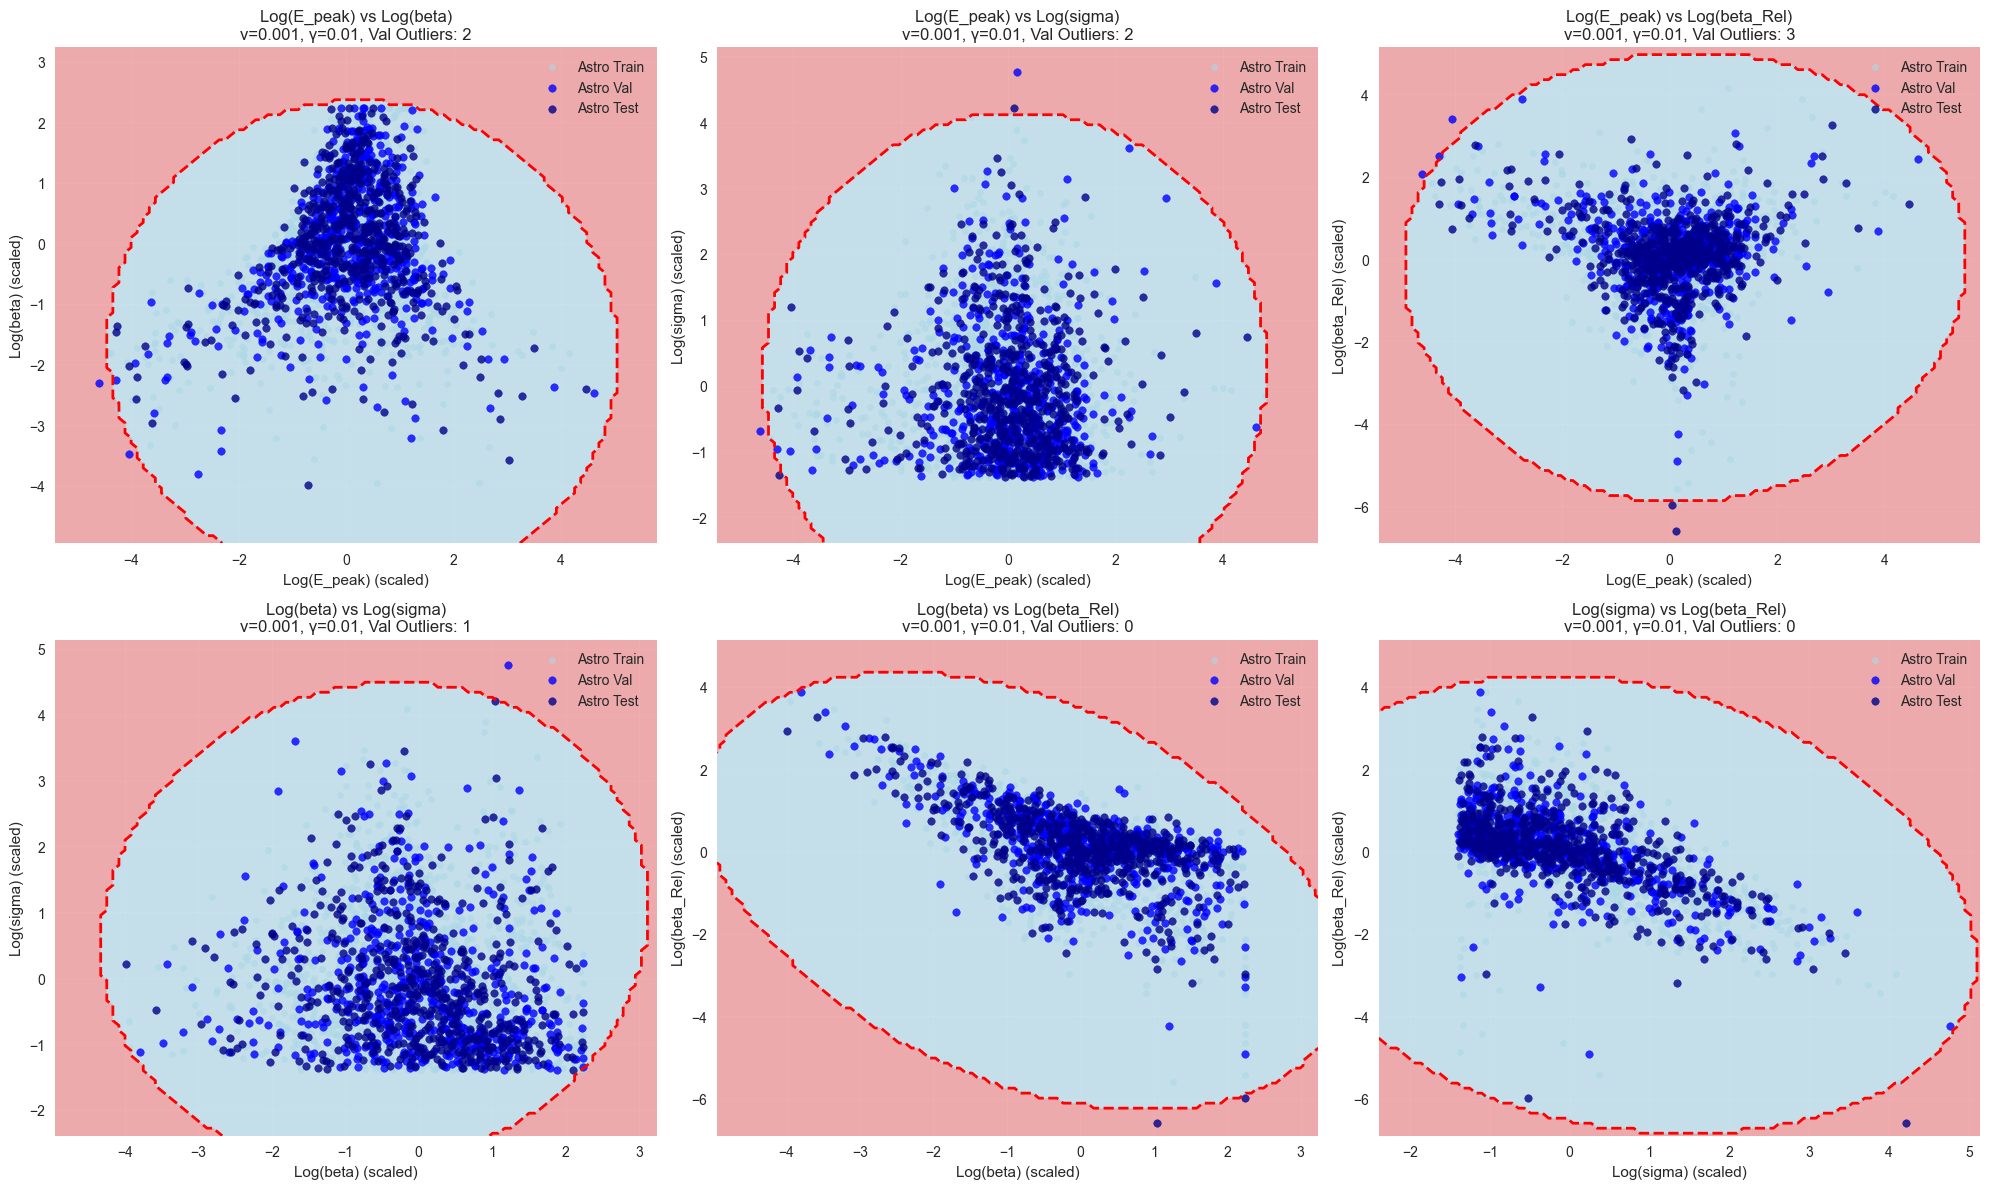


RESUMEN DE FRONTERAS POR PROYECCIÓN 2D:


,feature_pair,best_nu,best_gamma,val_outliers,val_outlier_rate
5,Log(sigma) vs Log(beta_Rel),0.001,0.01,0,0.000000
4,Log(beta) vs Log(beta_Rel),0.001,0.01,0,0.000000
3,Log(beta) vs Log(sigma),0.001,0.01,1,0.176678
0,Log(E_peak) vs Log(beta),0.001,0.01,2,0.353357
1,Log(E_peak) vs Log(sigma),0.001,0.01,2,0.353357
2,Log(E_peak) vs Log(beta_Rel),0.001,0.01,3,0.530035


In [821]:
# Definir parámetros para búsqueda
nu_values_vis = [0.001, 0.005, 0.01, 0.02, 0.05]
gamma_values_vis = [0.01, 0.1, 1.0]  # Pocos valores para velocidad
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']

print("Analizando fronteras de decisión en proyecciones 2D...")
print("Esto puede tomar unos minutos...")

# Ejecutar análisis
boundary_results = plot_decision_boundaries_4f(
    X_train, X_val, X_test, y_train, y_val, y_test,
    nu_values_vis, gamma_values_vis, feature_names
)

print("\nRESUMEN DE FRONTERAS POR PROYECCIÓN 2D:")
print("="*60)
display(boundary_results.sort_values('val_outliers'))


In [822]:
def interactive_parameter_analysis(X_train, X_val, X_test, y_train, y_val, y_test, 
                                 nu_values, gamma_values):
    """
    Análisis sistemático de hiperparámetros con visualización de resultados
    """
    
    # Escalar datos 4D
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    results = []
    models = {}
    
    print("Probando combinaciones de hiperparámetros...")
    print("Formato: [nu, gamma] -> val_outliers, test_outliers")
    
    for nu in nu_values:
        for gamma in gamma_values:
            # Entrenar modelo
            model = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
            model.fit(X_train_scaled)
            
            # Predecir en conjuntos
            val_preds = model.predict(X_val_scaled)
            test_preds = model.predict(X_test_scaled)
            
            # Contar outliers
            val_outliers = np.sum(val_preds == -1)
            test_outliers = np.sum(test_preds == -1)
            
            # Contar outliers astro (falsos positivos)
            val_astro_outliers = np.sum((val_preds == -1) & (y_val == 0))
            test_astro_outliers = np.sum((test_preds == -1) & (y_test == 0))
            
            results.append({
                'nu': nu,
                'gamma': gamma,
                'val_outliers': val_outliers,
                'test_outliers': test_outliers,
                'val_astro_outliers': val_astro_outliers,
                'test_astro_outliers': test_astro_outliers,
                'val_outlier_rate': val_outliers / len(X_val_scaled) * 100,
                'test_outlier_rate': test_outliers / len(X_test_scaled) * 100
            })
            
            models[(nu, gamma)] = model
            
            print(f"[{nu:5.3f}, {gamma:4.1f}] -> {val_outliers:3d}, {test_outliers:3d} "
                  f"(astro: {val_astro_outliers:2d}, {test_astro_outliers:2d})")
    
    return pd.DataFrame(results), models

print("Función de análisis interactivo definida ✓")


Función de análisis interactivo definida ✓


In [823]:
# Parámetros más detallados para el análisis
nu_values_detailed = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
gamma_values_detailed = [0.01, 0.1, 1.0]

print("Ejecutando análisis detallado de hiperparámetros...")
param_results, trained_models = interactive_parameter_analysis(
    X_train, X_val, X_test, y_train, y_val, y_test,
    nu_values_detailed, gamma_values_detailed
)

# Mostrar resultados ordenados
print("\nRESULTADOS ORDENADOS POR OUTLIERS EN VALIDACIÓN:")
display(param_results.sort_values(['val_astro_outliers', 'val_outliers']).head(10))


Ejecutando análisis detallado de hiperparámetros...
Probando combinaciones de hiperparámetros...
Formato: [nu, gamma] -> val_outliers, test_outliers
[0.001,  0.0] ->   4,   1 (astro:  4,  1)
[0.001,  0.1] ->  10,   6 (astro: 10,  6)


[0.001,  1.0] ->  69,  77 (astro: 69, 77)
[0.002,  0.0] ->   4,   1 (astro:  4,  1)
[0.002,  0.1] ->  10,   6 (astro: 10,  6)
[0.002,  1.0] ->  63,  72 (astro: 63, 72)
[0.005,  0.0] ->   6,   4 (astro:  6,  4)
[0.005,  0.1] ->  10,   6 (astro: 10,  6)
[0.005,  1.0] ->  63,  70 (astro: 63, 70)
[0.010,  0.0] ->   8,   6 (astro:  8,  6)
[0.010,  0.1] ->  12,   7 (astro: 12,  7)
[0.010,  1.0] ->  63,  71 (astro: 63, 71)
[0.020,  0.0] ->  12,  12 (astro: 12, 12)
[0.020,  0.1] ->  17,  12 (astro: 17, 12)
[0.020,  1.0] ->  63,  72 (astro: 63, 72)
[0.050,  0.0] ->  32,  35 (astro: 32, 35)
[0.050,  0.1] ->  37,  33 (astro: 37, 33)
[0.050,  1.0] ->  64,  71 (astro: 64, 71)

RESULTADOS ORDENADOS POR OUTLIERS EN VALIDACIÓN:


,nu,gamma,val_outliers,test_outliers,val_astro_outliers,test_astro_outliers,val_outlier_rate,test_outlier_rate
0,0.001,0.01,4,1,4,1,0.706714,0.176367
3,0.002,0.01,4,1,4,1,0.706714,0.176367
6,0.005,0.01,6,4,6,4,1.060071,0.705467
9,0.010,0.01,8,6,8,6,1.413428,1.058201
1,0.001,0.10,10,6,10,6,1.766784,1.058201
4,0.002,0.10,10,6,10,6,1.766784,1.058201
7,0.005,0.10,10,6,10,6,1.766784,1.058201
10,0.010,0.10,12,7,12,7,2.120141,1.234568
12,0.020,0.01,12,12,12,12,2.120141,2.116402
13,0.020,0.10,17,12,17,12,3.003534,2.116402


In [824]:
print("ANÁLISIS DE RECOMENDACIONES:")
print("="*50)

# Encontrar mejores combinaciones según diferentes criterios
best_val_outliers = param_results.loc[param_results['val_outliers'].idxmin()]
best_val_astro = param_results.loc[param_results['val_astro_outliers'].idxmin()]
best_consistency = param_results.loc[np.abs(param_results['val_outliers'] - param_results['test_outliers']).idxmin()]

print("MEJORES HIPERPARÁMETROS POR CRITERIO:")
print("-" * 40)
print(f"1. Mínimos outliers en validación:")
print(f"   ν={best_val_outliers['nu']:.3f}, γ={best_val_outliers['gamma']:.1f}")
print(f"   Val outliers: {best_val_outliers['val_outliers']}, Test outliers: {best_val_outliers['test_outliers']}")

print(f"\n2. Mínimos falsos positivos (astro como outliers):")
print(f"   ν={best_val_astro['nu']:.3f}, γ={best_val_astro['gamma']:.1f}")
print(f"   Val astro outliers: {best_val_astro['val_astro_outliers']}, Test astro outliers: {best_val_astro['test_astro_outliers']}")

print(f"\n3. Mayor consistencia Val-Test:")
print(f"   ν={best_consistency['nu']:.3f}, γ={best_consistency['gamma']:.1f}")
print(f"   Val outliers: {best_consistency['val_outliers']}, Test outliers: {best_consistency['test_outliers']}")

# Filtrar candidatos razonables (pocos falsos positivos)
reasonable_candidates = param_results[param_results['val_astro_outliers'] <= 5]  # Max 5 falsos +

if len(reasonable_candidates) > 0:
    print(f"\nCANDIDATOS RAZONABLES (≤5 falsos positivos):")
    print("-" * 40)
    display(reasonable_candidates.sort_values(['val_astro_outliers', 'val_outliers']))
    
    recommended = reasonable_candidates.loc[reasonable_candidates['val_outliers'].idxmin()]
    print(f"\nRECOMENDACIÓN FINAL:")
    print(f"ν = {recommended['nu']:.3f}, γ = {recommended['gamma']:.1f}")
    print(f"• Val outliers: {recommended['val_outliers']} ({recommended['val_outlier_rate']:.1f}%)")
    print(f"• Test outliers: {recommended['test_outliers']} ({recommended['test_outlier_rate']:.1f}%)")
    print(f"• Falsos positivos val: {recommended['val_astro_outliers']}")
    print(f"• Falsos positivos test: {recommended['test_astro_outliers']}")
else:
    print(f"\n⚠ Todos los modelos generan >5 falsos positivos")
    print(f"Considera usar nu más pequeño o gamma más grande")

ANÁLISIS DE RECOMENDACIONES:
MEJORES HIPERPARÁMETROS POR CRITERIO:
----------------------------------------
1. Mínimos outliers en validación:
   ν=0.001, γ=0.0
   Val outliers: 4.0, Test outliers: 1.0

2. Mínimos falsos positivos (astro como outliers):
   ν=0.001, γ=0.0
   Val astro outliers: 4.0, Test astro outliers: 1.0

3. Mayor consistencia Val-Test:
   ν=0.020, γ=0.0
   Val outliers: 12.0, Test outliers: 12.0

CANDIDATOS RAZONABLES (≤5 falsos positivos):
----------------------------------------


,nu,gamma,val_outliers,test_outliers,val_astro_outliers,test_astro_outliers,val_outlier_rate,test_outlier_rate
0,0.001,0.01,4,1,4,1,0.706714,0.176367
3,0.002,0.01,4,1,4,1,0.706714,0.176367



RECOMENDACIÓN FINAL:
ν = 0.001, γ = 0.0
• Val outliers: 4.0 (0.7%)
• Test outliers: 1.0 (0.2%)
• Falsos positivos val: 4.0
• Falsos positivos test: 1.0


In [825]:
def visualize_3d_projections(model, X_train, X_val, X_test, y_train, y_val, y_test, 
                           feature_names, scaler):
    """
    Visualizamos el modelo en proyecciones 3D seleccionadas
    """
    fig = plt.figure(figsize=(20, 6))
    
    # Tres proyecciones 3D más informativas
    projections_3d = [
        (0, 1, 2),  # E_peak, beta, sigma
        (0, 1, 3),  # E_peak, beta, beta_Rel  
        (0, 2, 3)   # E_peak, sigma, beta_Rel
    ]
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    for i, (f1, f2, f3) in enumerate(projections_3d):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # Máscaras para astro
        astro_train = (y_train == 0)
        astro_val = (y_val == 0)
        astro_test = (y_test == 0)
        
        # Predicciones
        train_preds = model.predict(X_train_scaled)
        val_preds = model.predict(X_val_scaled)
        test_preds = model.predict(X_test_scaled)
        
        # Plot puntos normales
        ax.scatter(X_train_scaled[astro_train & (train_preds == 1), f1],
                  X_train_scaled[astro_train & (train_preds == 1), f2],
                  X_train_scaled[astro_train & (train_preds == 1), f3],
                  c='lightblue', alpha=0.6, s=20, label='Astro Normal')
        
        # Plot outliers
        ax.scatter(X_val_scaled[astro_val & (val_preds == -1), f1],
                  X_val_scaled[astro_val & (val_preds == -1), f2],
                  X_val_scaled[astro_val & (val_preds == -1), f3],
                  c='red', alpha=0.8, s=60, marker='x', label='Astro Outliers')
        
        ax.set_xlabel(feature_names[f1])
        ax.set_ylabel(feature_names[f2])
        ax.set_zlabel(feature_names[f3])
        ax.set_title(f'{feature_names[f1]}-{feature_names[f2]}-{feature_names[f3]}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

print("Función de visualización 3D definida")
print(f"\nPara ejecutar visualización 3D del modelo seleccionado:")
print("visualize_3d_projections(selected_model, X_train, X_val, X_test, y_train, y_val, y_test, feature_names, scaler)")


Función de visualización 3D definida

Para ejecutar visualización 3D del modelo seleccionado:
visualize_3d_projections(selected_model, X_train, X_val, X_test, y_train, y_val, y_test, feature_names, scaler)


In [826]:
# visualizar el modelo recomendado automáticamente:
selected_nu = 0.01  # Ajustar según resultados observados
selected_gamma = 0.1  # Ajustar según resultados observados

# Entrenar modelo final con todos los datos astro (train + val)
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# Scaler final
scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)

# Modelo final
final_model = OneClassSVM(kernel='rbf', nu=selected_nu, gamma=selected_nu)
final_model.fit(X_final_train_scaled)

print(f"Modelo final entrenado:")
print(f"  - Datos de entrenamiento: {X_final_train_scaled.shape[0]} muestras")
print(f"  - Hiperparámetros: ν={selected_nu}, γ={selected_nu}")

Modelo final entrenado:
  - Datos de entrenamiento: 2264 muestras
  - Hiperparámetros: ν=0.01, γ=0.01



Visualizando modelo recomendado (ν=0.001, γ=0.0):


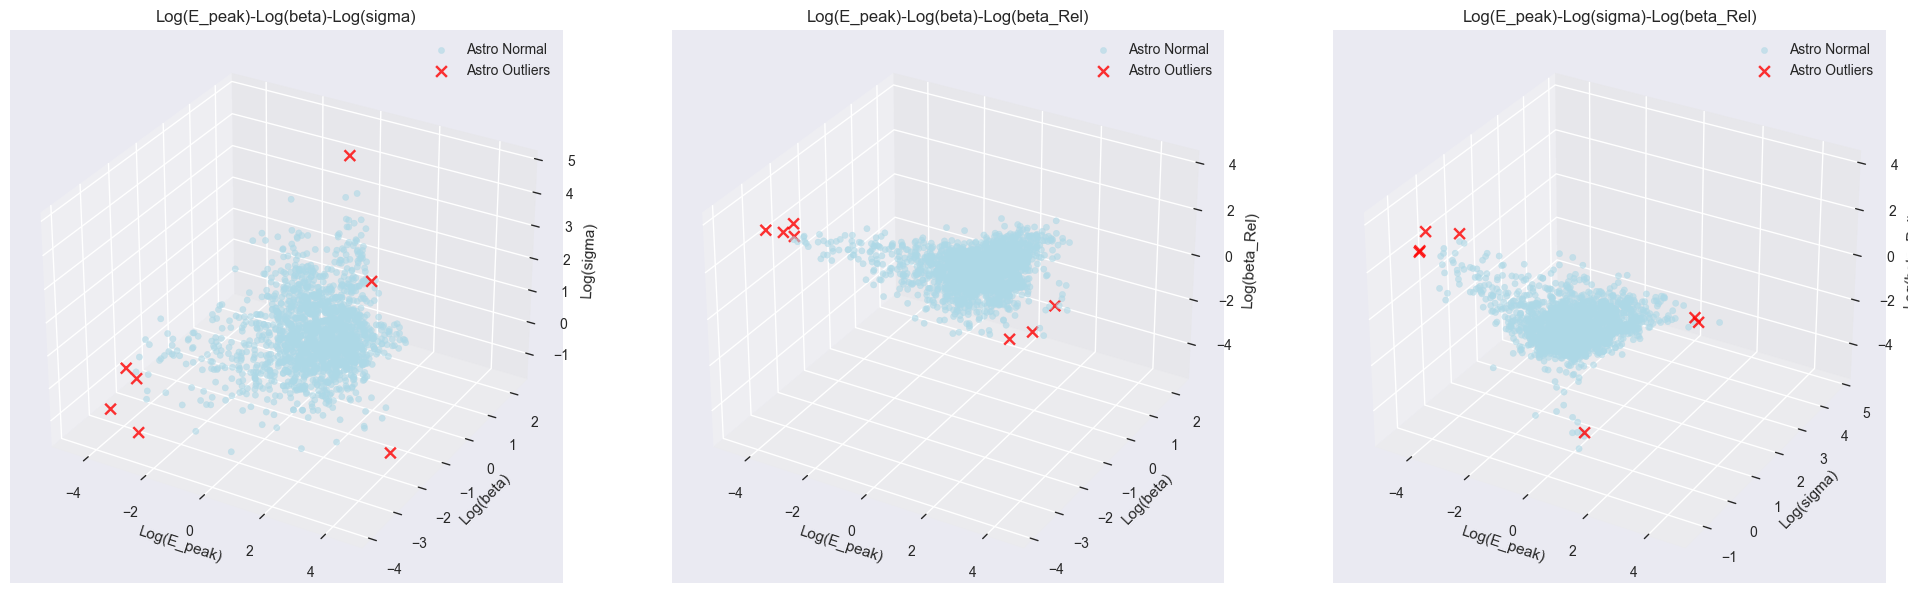

In [827]:
print(f"\nVisualizando modelo recomendado (ν={recommended['nu']:.3f}, γ={recommended['gamma']:.1f}):")
visualize_3d_projections(final_model, X_train, X_val, X_test, 
                        y_train, y_val, y_test, feature_names, scaler_final)

# UNIDs

In [828]:
# Cargar datos UnIDs
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

print("Datos UnIDs cargados:")
print(f"Shape: {df_unids.shape}")
print("Primeras filas:")
display(df_unids.head())

# Verificar columnas disponibles
print(f"Columnas disponibles: {list(df_unids.columns)}")

Datos UnIDs cargados:
Shape: (1125, 5)
Primeras filas:


,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


Columnas disponibles: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number']


In [829]:
# Extraer características 4F
feature_cols = ["Log(E_peak)", "Log(beta)", "Log(sigma_det)", "Log(beta_Rel)"]
X_unids_log = df_unids[feature_cols].values

print(f"Características extraídas: {feature_cols}")
print(f"Shape características UnIDs: {X_unids_log.shape}")

Características extraídas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']
Shape características UnIDs: (1125, 4)


In [830]:
# Escalar características UnIDs
X_unids_scaled = scaler_final.transform(X_unids_log)

print(f"UnIDs escalados: {X_unids_scaled.shape}")

# Paso 1: Calcular scores de decisión (valores continuos)
decision_scores = final_model.decision_function(X_unids_scaled)

# Paso 2: Predicciones binarias (inlier/outlier)
unids_preds = final_model.predict(X_unids_scaled)

# Contar outliers detectados
n_outliers = np.sum(unids_preds == -1)
outlier_percentage = n_outliers / len(unids_preds) * 100

print(f"RESULTADOS DE PREDICCIÓN:")
print(f"  - Total UnIDs analizadas: {len(unids_preds)}")
print(f"  - Outliers detectados: {n_outliers} ({outlier_percentage:.1f}%)")
print(f"  - Inliers detectados: {np.sum(unids_preds == 1)} ({100-outlier_percentage:.1f}%)")

# Paso 3: Calcular anomaly scores y rankings
# Invertir scores: valores más altos = más anómalos
anom_scores = -decision_scores

# Escalar a percentiles [0, 100]
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Agregar resultados al DataFrame
df_unids_results = df_unids.copy()
df_unids_results["svm_score"] = decision_scores
df_unids_results["prediction"] = unids_preds
df_unids_results["Anomaly_Score"] = anom_scores
df_unids_results["Anomaly_Rank(%)"] = anom_percent

print("Scores calculados y agregados al DataFrame")

UnIDs escalados: (1125, 4)
RESULTADOS DE PREDICCIÓN:
  - Total UnIDs analizadas: 1125
  - Outliers detectados: 8 (0.7%)
  - Inliers detectados: 1117 (99.3%)
Scores calculados y agregados al DataFrame


In [831]:
# Filtrar solo outliers y ordenar por anomaly rank
outliers_only = df_unids_results[df_unids_results["prediction"] == -1].copy()
outliers_sorted = outliers_only.sort_values(by="Anomaly_Rank(%)", ascending=False)

# Top 10 outliers más anómalos
top_10_outliers = outliers_sorted.head(10)

print(f"TOP 10 CANDIDATOS MÁS ANÓMALOS:")

# Mostrar información relevante
display_cols = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 
                'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']

if 'number' in df_unids_results.columns:
    display_cols = ['number'] + display_cols

display(top_10_outliers[display_cols].round(4))

# Estadísticas de los outliers
print(f"\nESTADÍSTICAS DE OUTLIERS:")
print(f"  - Anomaly Score promedio: {outliers_only['Anomaly_Score'].mean():.4f} ± {outliers_only['Anomaly_Score'].std():.4f}")
print(f"  - Anomaly Rank promedio: {outliers_only['Anomaly_Rank(%)'].mean():.1f}% ± {outliers_only['Anomaly_Rank(%)'].std():.1f}%")
print(f"  - SVM Score promedio: {outliers_only['svm_score'].mean():.4f} ± {outliers_only['svm_score'].std():.4f}")


TOP 10 CANDIDATOS MÁS ANÓMALOS:


,number,Log(E_peak),Log(beta),Log(sigma_det),Log(beta_Rel),svm_score,Anomaly_Score,Anomaly_Rank(%)
307,307,1.5101,0.0000,0.6173,-3.0458,-1.7979,1.7979,100.0000
166,166,1.3292,0.0000,0.6372,-2.4202,-0.5791,0.5791,72.2609
1116,1116,0.7714,-2.6198,0.7473,1.5993,-0.4619,0.4619,69.5936
285,285,-0.7468,-1.2457,0.6598,1.8748,-0.4514,0.4514,69.3545
1109,1109,-5.6280,-1.8477,0.6330,0.8389,-0.3904,0.3904,67.9680
562,562,-4.8902,-1.7852,0.8577,1.3178,-0.3791,0.3791,67.7101
564,564,1.4390,-2.5376,0.8658,1.3979,-0.0975,0.0975,61.3020
117,117,-5.4720,-1.6737,0.6652,0.6894,-0.0703,0.0703,60.6831



ESTADÍSTICAS DE OUTLIERS:
  - Anomaly Score promedio: 0.5285 ± 0.5427
  - Anomaly Rank promedio: 71.1% ± 12.4%
  - SVM Score promedio: -0.5285 ± 0.5427


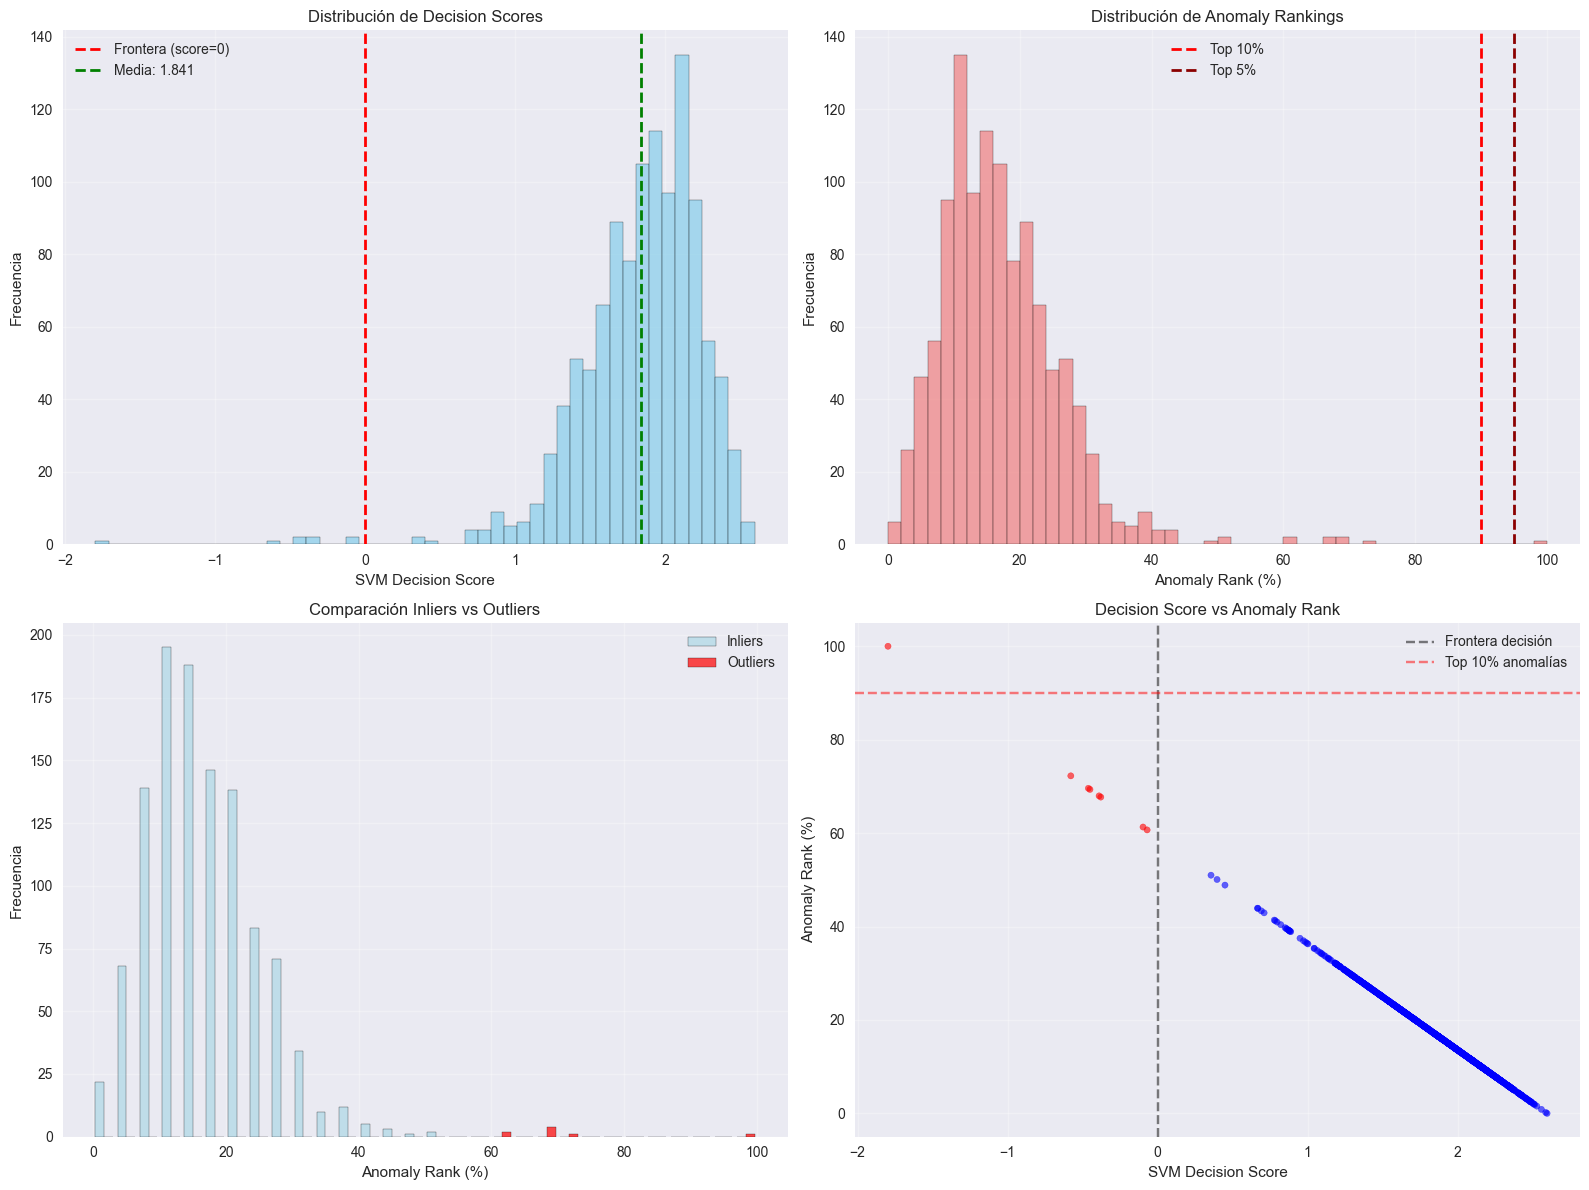

In [832]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de Decision Scores
ax1 = axes[0, 0]
ax1.hist(decision_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Frontera (score=0)')
ax1.axvline(decision_scores.mean(), color='green', linestyle='--', linewidth=2, 
           label=f'Media: {decision_scores.mean():.3f}')
ax1.set_xlabel('SVM Decision Score')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Decision Scores')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribución de Anomaly Ranks
ax2 = axes[0, 1]
ax2.hist(anom_percent, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.axvline(90, color='red', linestyle='--', linewidth=2, label='Top 10%')
ax2.axvline(95, color='darkred', linestyle='--', linewidth=2, label='Top 5%')
ax2.set_xlabel('Anomaly Rank (%)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Anomaly Rankings')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Outliers vs Inliers
ax3 = axes[1, 0]
outliers_scores = anom_percent[unids_preds == -1]
inliers_scores = anom_percent[unids_preds == 1]

ax3.hist([inliers_scores, outliers_scores], bins=30, alpha=0.7, 
         color=['lightblue', 'red'], label=['Inliers', 'Outliers'], 
         edgecolor='black')
ax3.set_xlabel('Anomaly Rank (%)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Comparación Inliers vs Outliers')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Scatter plot: Decision Score vs Anomaly Rank
ax4 = axes[1, 1]
colors = ['red' if pred == -1 else 'blue' for pred in unids_preds]
ax4.scatter(decision_scores, anom_percent, c=colors, alpha=0.6, s=20)
ax4.axvline(0, color='black', linestyle='--', alpha=0.5, label='Frontera decisión')
ax4.axhline(90, color='red', linestyle='--', alpha=0.5, label='Top 10% anomalías')
ax4.set_xlabel('SVM Decision Score')
ax4.set_ylabel('Anomaly Rank (%)')
ax4.set_title('Decision Score vs Anomaly Rank')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

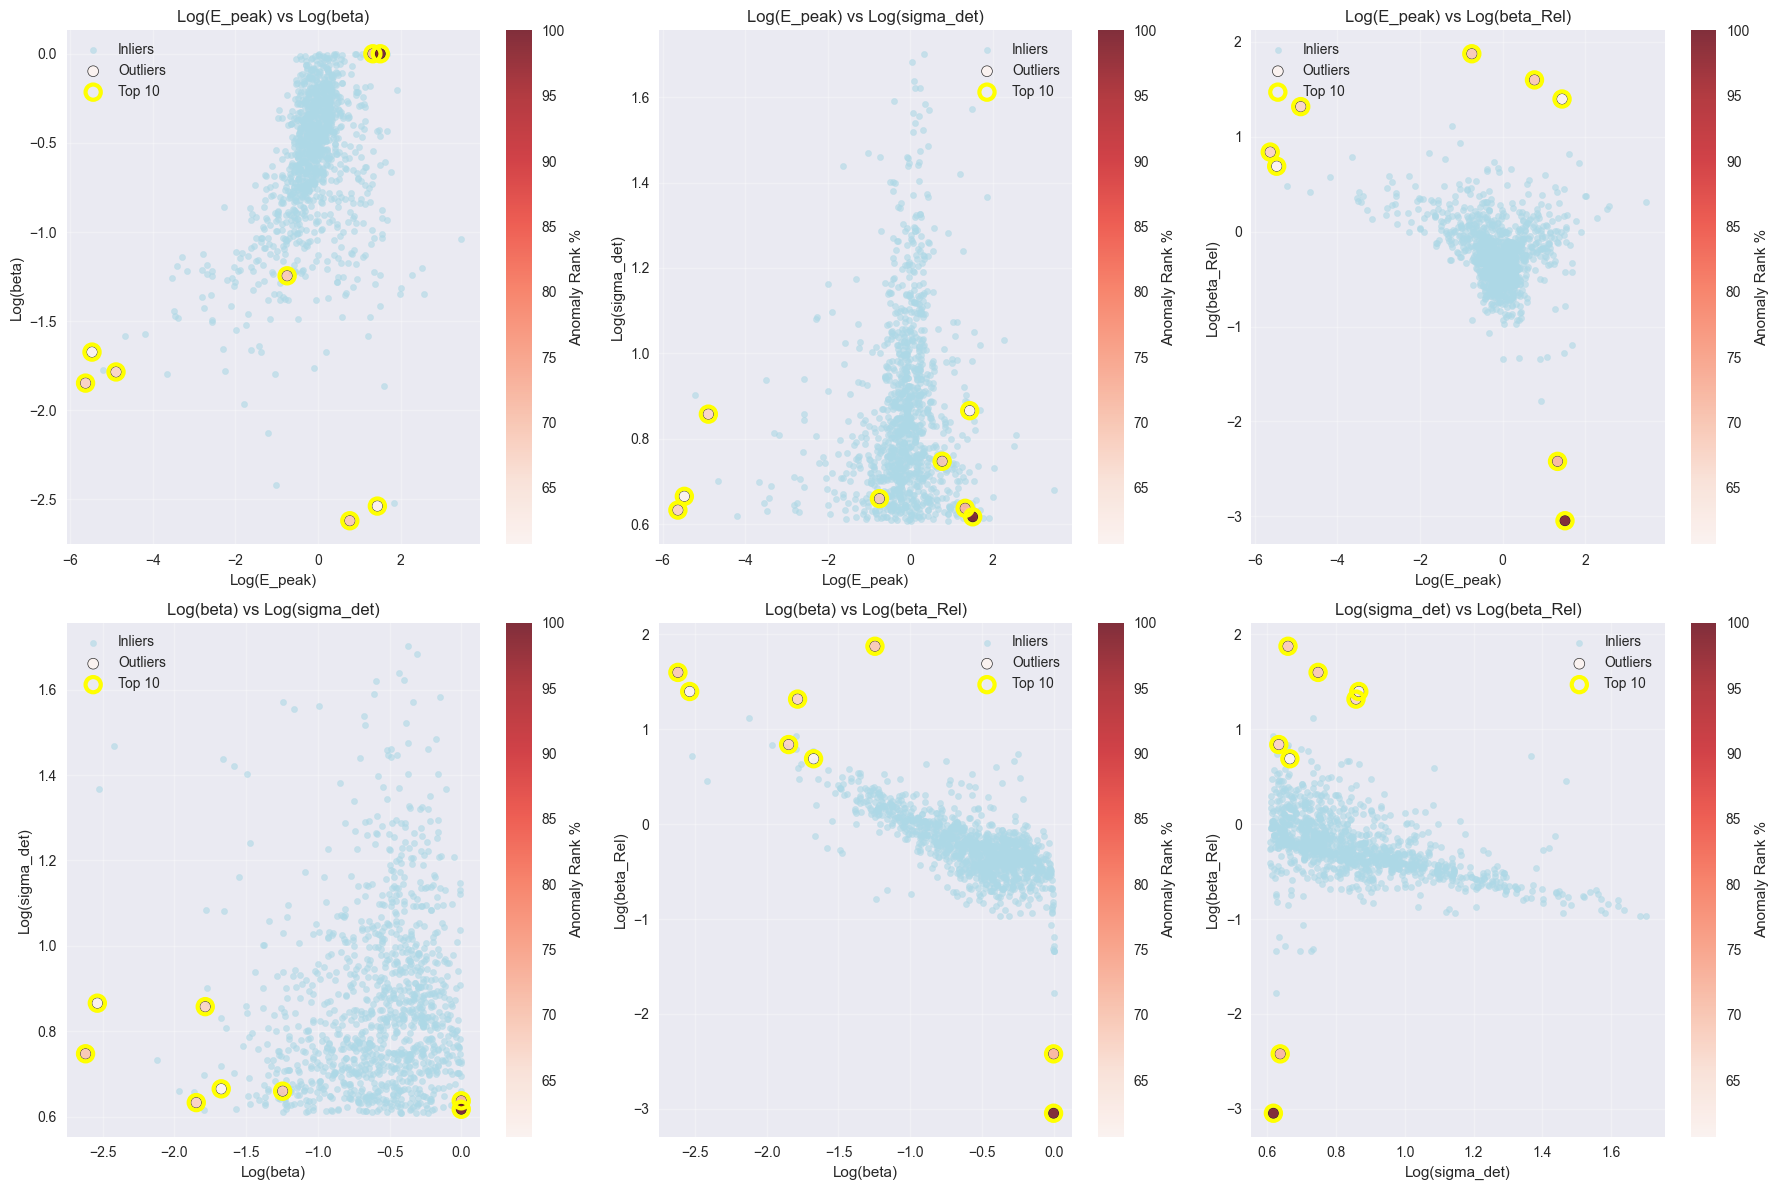

In [833]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Todas las combinaciones 2D de las 4 características
feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx//3, idx%3]
    
    # Separar inliers y outliers
    inliers_mask = unids_preds == 1
    outliers_mask = unids_preds == -1
    
    # Plot inliers
    ax.scatter(X_unids_log[inliers_mask, i], X_unids_log[inliers_mask, j], 
              c='lightblue', alpha=0.6, s=20, label='Inliers')
    
    # Plot outliers con colores según anomaly rank
    if np.any(outliers_mask):
        scatter = ax.scatter(X_unids_log[outliers_mask, i], X_unids_log[outliers_mask, j], 
                           c=anom_percent[outliers_mask], cmap='Reds', s=60, 
                           alpha=0.8, edgecolors='black', linewidth=0.5, label='Outliers')
        plt.colorbar(scatter, ax=ax, label='Anomaly Rank %')
    
    # Destacar top 10
    if len(top_10_outliers) > 0:
        top_10_indices = top_10_outliers.index
        ax.scatter(X_unids_log[top_10_indices, i], X_unids_log[top_10_indices, j], 
                  s=120, facecolors='none', edgecolors='yellow', linewidth=3, 
                  label=f'Top 10', marker='o')
    
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f'{feature_names[i]} vs {feature_names[j]}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [834]:
import os
os.makedirs('../data/results/ocsvm/4F/', exist_ok=True)

# Guardar DataFrame completo con scores
df_unids_results.to_csv('../data/results/ocsvm/4F/unids_with_anomaly_scores_4F.csv', index=False)

# Guardar solo outliers
outliers_sorted.to_csv('../data/results/ocsvm/4F/unids_outliers_4F.csv', index=False)

# Guardar top 10 más anómalos
top_10_outliers.to_csv('../data/results/ocsvm/4F/unids_top_10_anomalous_4F.csv', index=False)

# Reporte de resultados
report_content = f"""
{'='*60}
REPORTE DE ANOMALY SCORING - OCSVM 4F
{'='*60}

PARÁMETROS DEL MODELO:
- Kernel: RBF
- Nu: {selected_nu}
- Gamma: {selected_nu}
- Características: {', '.join(feature_names)}

RESULTADOS:
- Total UnIDs analizadas: {len(df_unids_results):,}
- Outliers detectados: {n_outliers:,} ({outlier_percentage:.1f}%)
- Inliers detectados: {len(df_unids_results) - n_outliers:,} ({100-outlier_percentage:.1f}%)

ESTADÍSTICAS DE SCORES:
- Decision Score promedio: {decision_scores.mean():.4f} ± {decision_scores.std():.4f}
- Decision Score rango: [{decision_scores.min():.4f}, {decision_scores.max():.4f}]
- Anomaly Rank promedio: {anom_percent.mean():.1f}% ± {anom_percent.std():.1f}%

TOP 5 CANDIDATOS MÁS ANÓMALOS:
{'-'*40}
"""

for i, (_, row) in enumerate(top_10_outliers.head(5).iterrows()):
    source_info = f"ID: {row.get('number', i)}" if 'number' in row else f"Índice: {i}"
    report_content += f"{i+1}. {source_info}\n"
    report_content += f"   Anomaly Rank: {row['Anomaly_Rank(%)']:.1f}%\n"
    report_content += f"   SVM Score: {row['svm_score']:.4f}\n"
    report_content += f"   Log(E_peak): {row['Log(E_peak)']:.3f}, Log(beta): {row['Log(beta)']:.3f}\n"
    report_content += f"   Log(sigma_det): {row['Log(sigma_det)']:.3f}, Log(beta_Rel): {row['Log(beta_Rel)']:.3f}\n\n"

# Guardar reporte
with open('../data/results/ocsvm/4F/anomaly_scoring_report_4F.txt', 'w') as f:
    f.write(report_content)

print("ARCHIVOS GUARDADOS:")
print("- unids_with_anomaly_scores_4F.csv - Dataset completo con scores")
print("- unids_outliers_4F.csv - Solo outliers detectados")
print("- unids_top_10_anomalous_4F.csv - Top 10 candidatos más anómalos")
print("- anomaly_scoring_report_4F.txt - Reporte detallado")

print(f"\nRESUMEN FINAL:")
print(f"{n_outliers} candidatos DM detectados de {len(df_unids_results)} fuentes UnID")
print(f"Tasa de detección: {outlier_percentage:.1f}%")
print(f"Top candidato: Anomaly Rank {top_10_outliers.iloc[0]['Anomaly_Rank(%)']:.1f}%")

ARCHIVOS GUARDADOS:
- unids_with_anomaly_scores_4F.csv - Dataset completo con scores
- unids_outliers_4F.csv - Solo outliers detectados
- unids_top_10_anomalous_4F.csv - Top 10 candidatos más anómalos
- anomaly_scoring_report_4F.txt - Reporte detallado

RESUMEN FINAL:
8 candidatos DM detectados de 1125 fuentes UnID
Tasa de detección: 0.7%
Top candidato: Anomaly Rank 100.0%


# Compare UNIDs most anomalous vs ANN most DM-like